In [ ]:
#!pip install tensorflow==2.9.3

In [1]:
#import splitfolders
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import os
import cv2

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
print(tf.__version__)

2.12.0


In [3]:
directory = "/content/drive/MyDrive/MLDS/Project/"

# **1. Transfer Learning for Video Classification**

## a) In this problem, we are trying to build a classifier that distinguishes videos of 5 different activities.

## b) Video Classification

## c) Moving Averages over Predictions for Video Classification

## d) Data Exploration and Pre-processing


### i. Load dataset from Sports Images Folder

### ii.  Randomly select 70% images from each folder as your training set, 0.15% as validation set, and the rest as your test set.


In [ ]:
# This Line of code will split the data into three folders

#splitfolders.ratio(directory+'Data/Sport Images/', output=directory+'Data/Split Sport Images/', seed=24, ratio=(0.7, 0.15,0.15))

### iii. In order for all the images to have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [5]:
batch_size = 64
img_height = 224
img_width = 224

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory+'Data/Split Sport Images/train',
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  directory+'Data/Split Sport Images/val',
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  directory+'Data/Split Sport Images/test',
  label_mode = 'categorical',
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2293 files belonging to 5 classes.
Found 490 files belonging to 5 classes.
Found 496 files belonging to 5 classes.


## e) Transfer Learning for Image Classification

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(224, 224),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomContrast(0.2),
  tf.keras.layers.RandomTranslation(0.2, 0.2),
])

In [ ]:
def train_resnet50(train_ds, val_ds, epochs, directory):
    """
    Returns model and history of model trained
    """

    ResNet50 = tf.keras.applications.resnet50.ResNet50(input_shape= (224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

    ResNet50.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    x = ResNet50(x, training=False)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(5, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)

    base_learning_rate = 0.0001
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss="categorical_crossentropy",
                metrics=['accuracy'])

    print(model.summary())

    #Initial Accuracy
    #loss0, accuracy0 = model.evaluate(val_ds)

    check_points = tf.keras.callbacks.ModelCheckpoint(filepath=directory+'Model/resnet50.h5', 
                                                    monitor='val_accuracy',
                                                    mode='max',
                                                    save_best_only=True)

    history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[check_points])

    #set best weigts
    model.load_weights(directory+'Model/resnet50.h5')
    return model, history

In [ ]:
def train_efficientnetB0(train_ds, val_ds, epochs, directory):
    """
    Returns model and history of model trained
    """

    EfficientNetB0 = tf.keras.applications.efficientnet.EfficientNetB0(input_shape= (224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

    EfficientNetB0.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    x = EfficientNetB0(x, training=False)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(5, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)

    base_learning_rate = 0.0001
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss="categorical_crossentropy",
                metrics=['accuracy'])

    print(model.summary())

    #Initial Accuracy
    #loss0, accuracy0 = model.evaluate(val_ds)

    check_points = tf.keras.callbacks.ModelCheckpoint(filepath=directory+'Model/efficientnetB0.h5', 
                                                    monitor='val_accuracy',
                                                    mode='max',
                                                    save_best_only=True)

    history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[check_points])

    #set best weigts
    model.load_weights(directory+'Model/efficientnetB0.h5')
    return model, history

In [ ]:
def train_vgg16(train_ds, val_ds, epochs, directory):
    """
    Returns model and history of model trained
    """

    VGG16 = tf.keras.applications.vgg16.VGG16(input_shape= (224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

    VGG16.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.vgg16.preprocess_input(x)
    x = VGG16(x, training=False)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(5, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)

    base_learning_rate = 0.0001
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss="categorical_crossentropy",
                metrics=['accuracy'])

    print(model.summary())

    #Initial Accuracy
    #loss0, accuracy0 = model.evaluate(val_ds)

    check_points = tf.keras.callbacks.ModelCheckpoint(filepath=directory+'Model/vgg16.h5', 
                                                    monitor='val_accuracy',
                                                    mode='max',
                                                    save_best_only=True,
                                                    save_weights_only=True)

    history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[check_points])

    #set best weigts
    model.load_weights(directory+'Model/vgg16.h5')
    return model, history

In [ ]:
def plot_graphs(history): 
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,2.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
def print_metrics(model, train_ds, test_ds):

    train_pred = model.predict(train_ds)
    train_pred = np.argmax(train_pred, axis=1)
    train_true = train_ds.classes
    
    test_pred = model.predict(test_ds)
    test_pred = np.argmax(test_pred, axis=1)
    test_true = test_ds.classes
    
    # Training Metrics
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(train_true, train_pred),display_labels=list(train_ds.class_indices.keys()))
    print("TRAINING METRICS \n")
    print("Confusion Matrix:\n")
    disp.plot()
    plt.show()
    print("Precision:",precision_score(train_true, train_pred, average='macro'))
    print("Recall:",recall_score(train_true, train_pred, average='macro'))
    print("Accuracy:",accuracy_score(train_true, train_pred))
    print("F1-score:",f1_score(train_true, train_pred, average='macro'),"\n\n")

    # Testing Metrics
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_true, test_pred),display_labels=list(test_ds.class_indices.keys()))
    print("TESTING METRICS \n")
    print("Confusion Matrix:\n")
    disp.plot()
    plt.show()
    print("Precision:",precision_score(test_true, test_pred, average='macro'))
    print("Recall:",recall_score(test_true, test_pred, average='macro'))
    print("Accuracy:",accuracy_score(test_true, test_pred))
    print("F1-score:",f1_score(test_true, test_pred, average='macro'),"\n")

In [4]:
def model_loader(name):
    if(name=='resnet50' or name=='resnet50_video'):
        pre_model = tf.keras.applications.resnet50.ResNet50(input_shape= (224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
        
    elif(name=='efficientnetB0' or name=='efficientnetB0_video'):
        pre_model = tf.keras.applications.efficientnet.EfficientNetB0(input_shape= (224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
    elif(name=='vgg16' or name=='vgg16_video'):
        pre_model = tf.keras.applications.vgg16.VGG16(input_shape= (224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
        
    pre_model.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = pre_model(inputs, training=False)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(5, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    
    model.load_weights(directory+'Model/' + name + '.h5')
    
    return model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 re_lu_1 (ReLU)              (None, 7, 7, 2048)        0         
                                                           

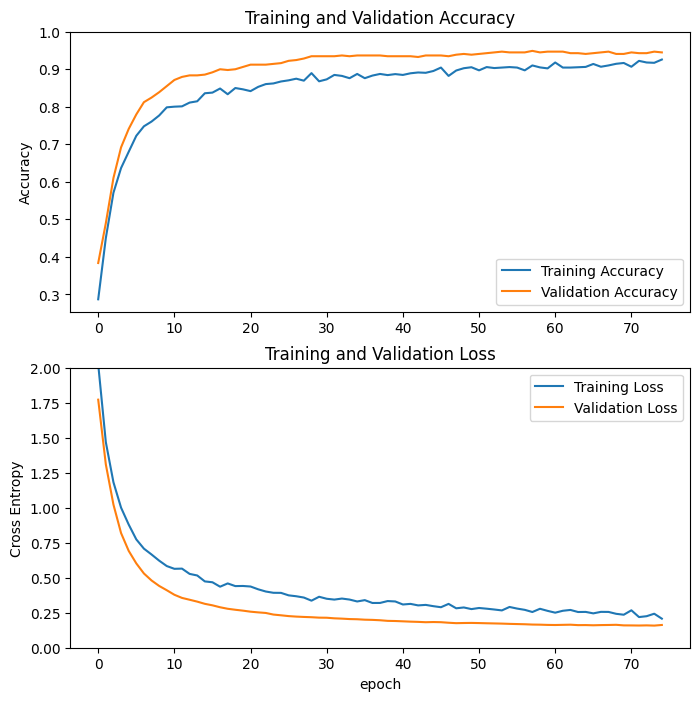

In [ ]:
# ResNet50
ResNet50, history = train_resnet50(train_ds, val_ds, 75, directory)
plot_graphs(history)

Found 2279 images belonging to 5 classes.
Found 495 images belonging to 5 classes.
8/8 [==============================] - 3s 455ms/step
TRAINING METRICS 

Confusion Matrix:



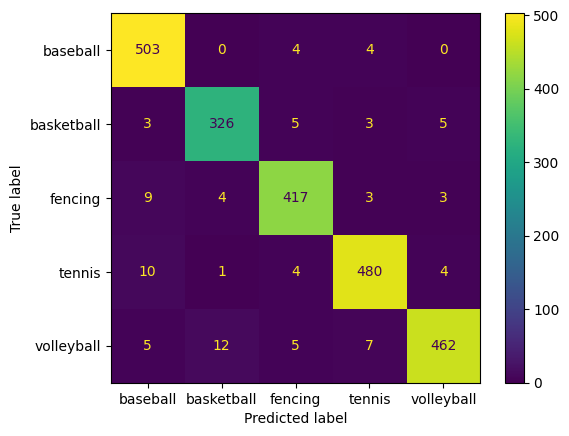

Precision: 0.9597185848256963
Recall: 0.9593687053114792
Accuracy: 0.960070206230803
F1-score: 0.9594183533299894 


TESTING METRICS 

Confusion Matrix:



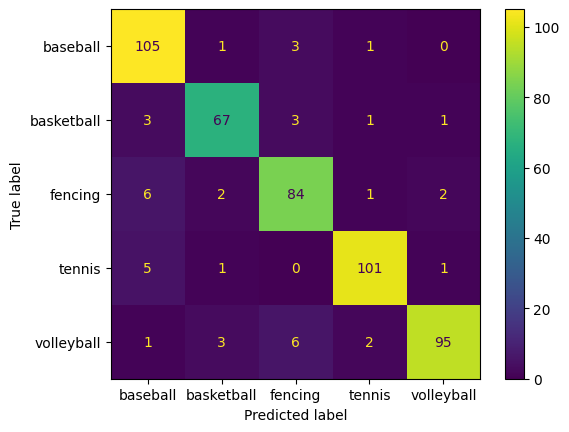

Precision: 0.9135663107361219
Recall: 0.9110249933338963
Accuracy: 0.9131313131313131
F1-score: 0.9116417639771942 



In [ ]:
res_train_ds = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(
        directory=directory+'Data/Split Sport Images/train', target_size=(224,224), batch_size=64, shuffle=False)
res_test_ds = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(
    directory=directory+'Data/Split Sport Images/test', target_size=(224,224), batch_size=64, shuffle=False)

ResNet50 = model_loader('resnet50')
print_metrics(ResNet50, res_train_ds, res_test_ds)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 re_lu (ReLU)                (None, 7, 7, 1280)        0         
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                               

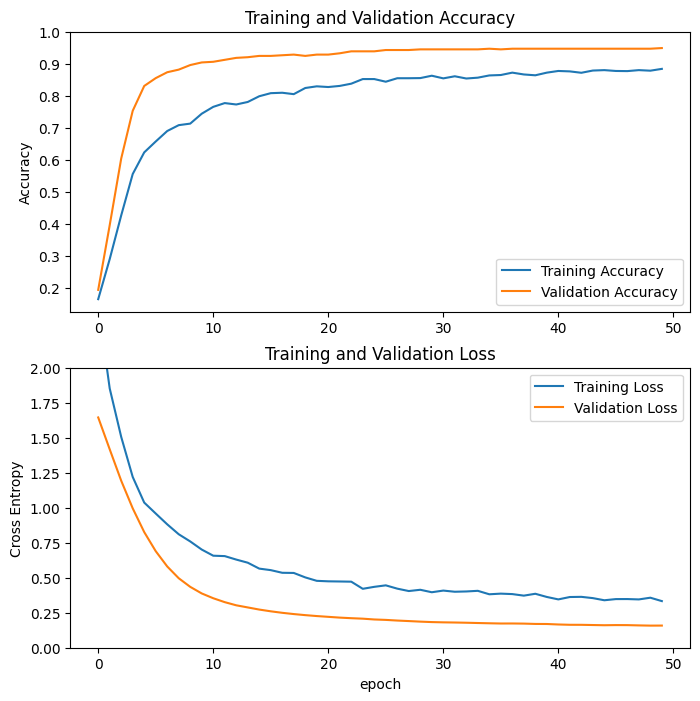

In [ ]:
# EfficientNetB0
EfficientNetB0, history = train_efficientnetB0(train_ds, val_ds, 50, directory)
plot_graphs(history)

Found 2279 images belonging to 5 classes.
Found 495 images belonging to 5 classes.
8/8 [==============================] - 2s 283ms/step
TRAINING METRICS 

Confusion Matrix:



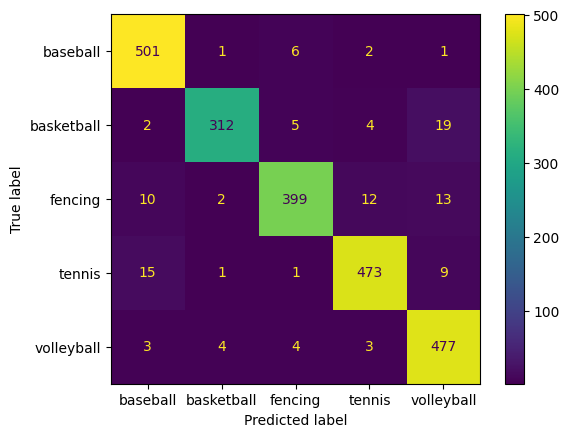

Precision: 0.9513027262084937
Recall: 0.9454462796205959
Accuracy: 0.9486616937253182
F1-score: 0.947830787323171 


TESTING METRICS 

Confusion Matrix:



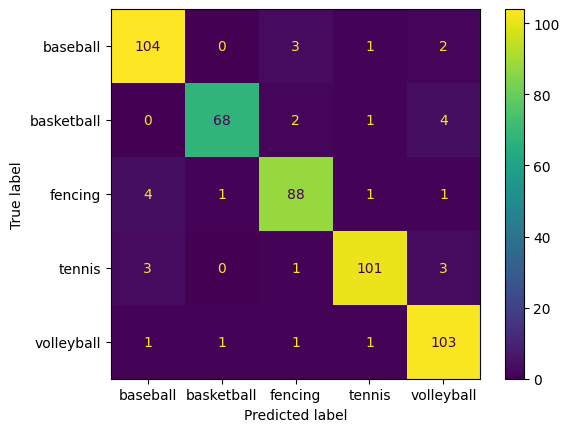

Precision: 0.9399449952314415
Recall: 0.9352478018419976
Accuracy: 0.9373737373737374
F1-score: 0.9371808409537505 



In [ ]:
en_train_ds = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
        directory=directory+'Data/Split Sport Images/train', target_size=(224,224), batch_size=64, shuffle=False)
en_test_ds = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
    directory=directory+'Data/Split Sport Images/test', target_size=(224,224), batch_size=64, shuffle=False)

EfficientNetB0 = model_loader('efficientnetB0')
print_metrics(EfficientNetB0, en_train_ds, en_test_ds)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 re_lu_2 (ReLU)              (None, 7, 7, 512)         0   

Epoch 29/75
36/36 [==============================] - 123s 3s/step - loss: 0.8039 - accuracy: 0.7091 - val_loss: 0.5894 - val_accuracy: 0.7898
Epoch 30/75
36/36 [==============================] - 120s 3s/step - loss: 0.7584 - accuracy: 0.7261 - val_loss: 0.5761 - val_accuracy: 0.7959
Epoch 31/75
36/36 [==============================] - 122s 3s/step - loss: 0.7652 - accuracy: 0.7205 - val_loss: 0.5687 - val_accuracy: 0.7959
Epoch 32/75
36/36 [==============================] - 121s 3s/step - loss: 0.7660 - accuracy: 0.7183 - val_loss: 0.5575 - val_accuracy: 0.8000
Epoch 33/75
36/36 [==============================] - 119s 3s/step - loss: 0.7334 - accuracy: 0.7414 - val_loss: 0.5466 - val_accuracy: 0.8102
Epoch 34/75
36/36 [==============================] - 121s 3s/step - loss: 0.7314 - accuracy: 0.7375 - val_loss: 0.5350 - val_accuracy: 0.8143
Epoch 35/75
36/36 [==============================] - 121s 3s/step - loss: 0.7299 - accuracy: 0.7423 - val_loss: 0.5251 - val_accuracy: 0.8163
Epoch 

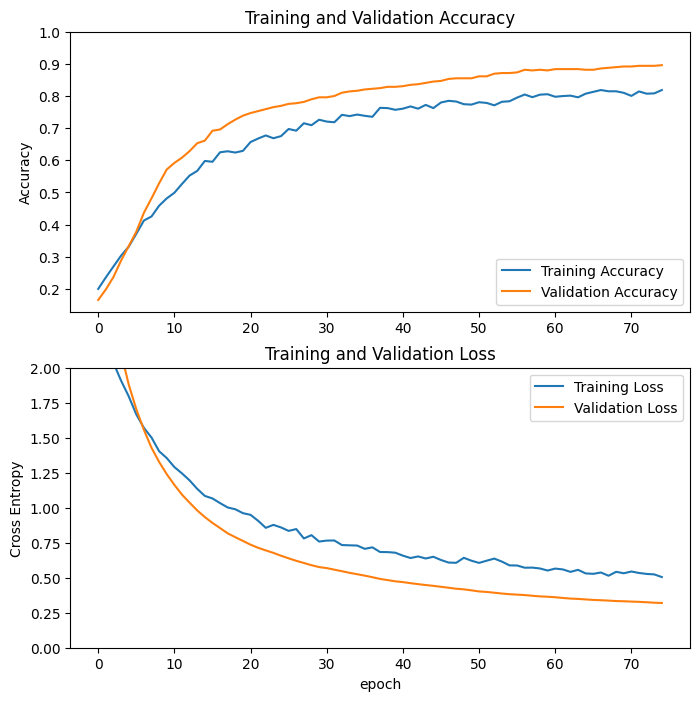

In [ ]:
# VGG16
VGG16, history = train_vgg16(train_ds, val_ds, 75, directory)
plot_graphs(history)

Found 2279 images belonging to 5 classes.
Found 495 images belonging to 5 classes.
8/8 [==============================] - 15s 2s/step
TRAINING METRICS 

Confusion Matrix:



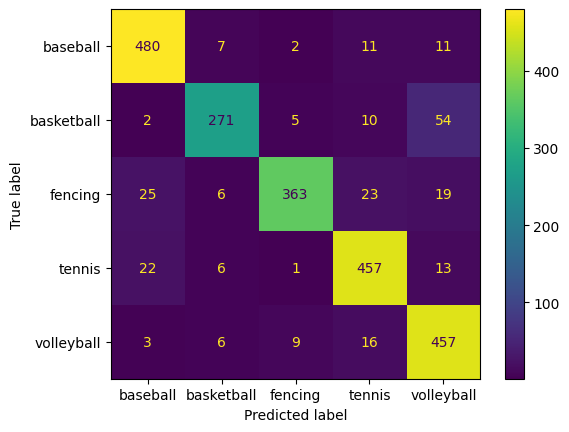

Precision: 0.896382985243618
Recall: 0.8821772667208755
Accuracy: 0.8898639754278193
F1-score: 0.8867809940948673 


TESTING METRICS 

Confusion Matrix:



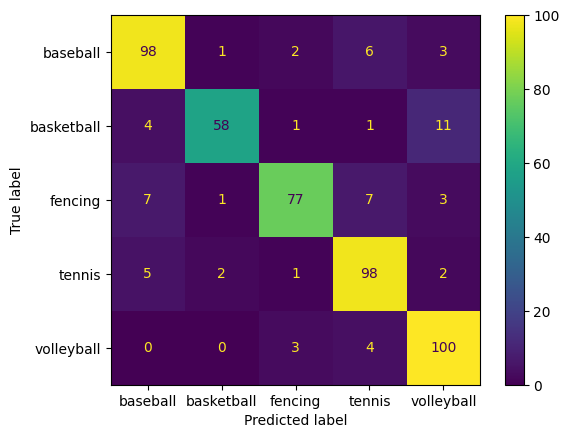

Precision: 0.8793926762204208
Recall: 0.8633511173383284
Accuracy: 0.8707070707070707
F1-score: 0.8684012552420537 



In [ ]:
vgg_train_ds = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
        directory=directory+'Data/Split Sport Images/train', target_size=(224,224), batch_size=64, shuffle=False)
vgg_test_ds = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=directory+'Data/Split Sport Images/test', target_size=(224,224), batch_size=64, shuffle=False)

VGG16 = model_loader('vgg16')
print_metrics(VGG16, vgg_train_ds, vgg_test_ds)

## f)  Video Classification Using Moving Averages

In [ ]:
#Using the best ResNet50 model on train data and again re-training it with validation and test data 

# Using 25 epochs by "ELBOW" method to avoid overfitting the data
ResNet50 = model_loader('resnet50')
base_learning_rate = 0.001
ResNet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
            loss="categorical_crossentropy",
            metrics=['accuracy'])

print(ResNet50.summary())

history = ResNet50.fit(val_ds.concatenate(test_ds),
                epochs=25)

ResNet50.save_weights('Model/resnet50_video.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 re_lu (ReLU)                (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2048)              0     

In [ ]:
#Using the best EfficientNetB0 model on train data and again re-training it with validation and test data 

# Using 25 epochs by "ELBOW" method to avoid overfitting the data
EfficientNetB0 = model_loader('efficientnetB0')
base_learning_rate = 0.001
EfficientNetB0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
            loss="categorical_crossentropy",
            metrics=['accuracy'])

print(EfficientNetB0.summary())

history = EfficientNetB0.fit(val_ds.concatenate(test_ds),
                epochs=25)
EfficientNetB0.save_weights('Model/efficientnetB0_video.h5')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 re_lu_1 (ReLU)              (None, 7, 7, 1280)        0         
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_1 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0   

In [ ]:
#Using the best VGG16 model on train data and again re-training it with validation and test data 

# Using 25 epochs by "ELBOW" method to avoid overfitting the data
VGG16 = model_loader('vgg16')
base_learning_rate = 0.001
VGG16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
            loss="categorical_crossentropy",
            metrics=['accuracy'])

print(VGG16.summary())

history = VGG16.fit(val_ds.concatenate(test_ds),
                epochs=25)
VGG16.save_weights('Model/vgg16_video.h5')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 re_lu_2 (ReLU)              (None, 7, 7, 512)         0         
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 512)               0   

In [5]:
videolocs = [os.path.join(root, name)
             for root, dirs, files in os.walk(directory + "Data/Sport Videos/")
             for name in files]

In [6]:
def get_labels(model, name):
    true_labels = []
    pred_labels = []

    i=0

    for video in videolocs:

        if(i%50 == 0 ):
            print("\n\nVIDEOS PROCESSED:",i,"\n\n")
        videoObj = cv2.VideoCapture(video)

        frames = []
        count = 0
        sum_pred = np.zeros(5)

        # function extract frames
        success, image = videoObj.read()
        
        #Using all the frames in the video for prediction 
        while success:
            image = cv2.resize(image,(224,224))
            
            if(name=='resnet50'):
                image = tf.keras.applications.resnet50.preprocess_input(image)
            elif(name=='efficientnetB0'):
                image = tf.keras.applications.efficientnet.preprocess_input(image)
            elif(name=='vgg16'):
                image = tf.keras.applications.vgg16.preprocess_input(image)
                
            frames.append(image)
            count += 1

            # function extract frames
            success, image = videoObj.read()

        frames = np.asarray(frames)
        frames = frames.reshape((count, 224, 224, 3))
        softmax_prob = model.predict(frames)
        sum_pred += np.sum(softmax_prob, axis=0)

        #Getting Average probability distribution
        pred = sum_pred/count

        #Getting the maximum probability class
        pred = np.argmax(pred)

        true = -1
        category = video.split("/")[-2]
        if(category=='BaseballPitch'):
            true = 0
        elif(category=='Basketball'):
            true = 1
        elif(category=='Fencing'):
            true = 2
        elif(category=='TennisSwing'):
            true = 3
        elif(category=='VolleyballSpiking'):
            true = 4

        i+=1
        true_labels.append(true)
        pred_labels.append(pred)
    
    return true_labels, pred_labels

In [7]:
def print_video_metrics(true_labels, pred_labels):
    # Metrics
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(true_labels, pred_labels),display_labels=['baseball', 'basketball', 'fencing', 'tennis', 'volleyball'])
    print("METRICS \n")
    print("Confusion Matrix:\n")
    disp.plot()
    plt.show()
    print("Precision:",precision_score(true_labels, pred_labels, average='macro', zero_division=1))
    print("Recall:",recall_score(true_labels, pred_labels, average='macro', zero_division=1))
    print("Accuracy:",accuracy_score(true_labels, pred_labels))
    print("F1-score:",f1_score(true_labels, pred_labels, average='macro', zero_division=1),"\n\n")

In [10]:
ResNet50 = model_loader('resnet50_video')
true_labels, res_pred_labels = get_labels(ResNet50, 'resnet50')



VIDEOS PROCESSED: 0 


3/3 [==============================] - 1s 366ms/step


VIDEOS PROCESSED: 50 


4/4 [==============================] - 0s 85ms/step


VIDEOS PROCESSED: 100 


6/6 [==============================] - 0s 86ms/step


VIDEOS PROCESSED: 150 


4/4 [==============================] - 0s 86ms/step


VIDEOS PROCESSED: 200 


4/4 [==============================] - 0s 86ms/step


VIDEOS PROCESSED: 250 


4/4 [==============================] - 0s 85ms/step


VIDEOS PROCESSED: 300 


4/4 [==============================] - 0s 85ms/step


VIDEOS PROCESSED: 350 


3/3 [==============================] - 0s 84ms/step


VIDEOS PROCESSED: 400 


5/5 [==============================] - 0s 85ms/step


VIDEOS PROCESSED: 450 


8/8 [==============================] - 1s 86ms/step


VIDEOS PROCESSED: 500 


9/9 [==============================] - 1s 87ms/step


VIDEOS PROCESSED: 550 


3/3 [==============================] - 0s 84ms/step


VIDEOS PROCESSED: 600 


4/4 [======================

METRICS FOR RESNET50:
METRICS 

Confusion Matrix:



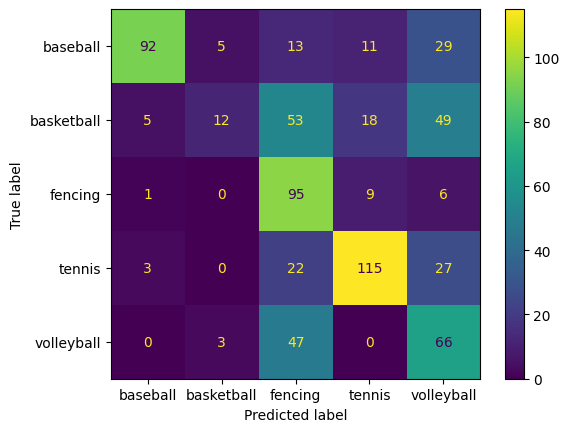

Precision: 0.6096899820460177
Recall: 0.5628737403594998
Accuracy: 0.5580029368575624
F1-score: 0.5224761334495023 




In [12]:
# Metrics for ResNet50
print("METRICS FOR RESNET50:")
print_video_metrics(true_labels, res_pred_labels)

In [8]:
EfficientNetB0 = model_loader('efficientnetB0_video')
true_labels, en_pred_labels = get_labels(EfficientNetB0, 'efficientnetB0')

16705208/16705208 [==============================] - 0s 0us/step


VIDEOS PROCESSED: 0 


3/3 [==============================] - 1s 338ms/step


VIDEOS PROCESSED: 50 


4/4 [==============================] - 0s 48ms/step


VIDEOS PROCESSED: 100 


6/6 [==============================] - 0s 49ms/step


VIDEOS PROCESSED: 150 


4/4 [==============================] - 0s 50ms/step


VIDEOS PROCESSED: 200 


4/4 [==============================] - 0s 49ms/step


VIDEOS PROCESSED: 250 


4/4 [==============================] - 0s 50ms/step


VIDEOS PROCESSED: 300 


4/4 [==============================] - 0s 48ms/step


VIDEOS PROCESSED: 350 


3/3 [==============================] - 0s 48ms/step


VIDEOS PROCESSED: 400 


5/5 [==============================] - 0s 49ms/step


VIDEOS PROCESSED: 450 


8/8 [==============================] - 0s 50ms/step


VIDEOS PROCESSED: 500 


9/9 [==============================] - 0s 48ms/step


VIDEOS PROCESSED: 550 


3/3 [==============================] - 0s

METRICS FOR EfficientNetB0:
METRICS 

Confusion Matrix:



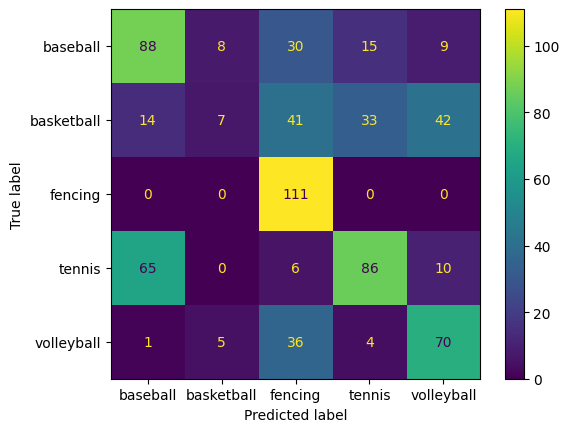

Precision: 0.5053769577861015
Recall: 0.5512359785839849
Accuracy: 0.5315712187958884
F1-score: 0.4872107413692068 




In [9]:
# Metrics for EfficientNetB0
print("METRICS FOR EfficientNetB0:")
print_video_metrics(true_labels, en_pred_labels)

In [10]:
VGG16 = model_loader('vgg16_video')
true_labels, vgg_pred_labels = get_labels(VGG16, 'vgg16')

58889256/58889256 [==============================] - 0s 0us/step


VIDEOS PROCESSED: 0 


3/3 [==============================] - 2s 1s/step


VIDEOS PROCESSED: 50 


4/4 [==============================] - 0s 117ms/step


VIDEOS PROCESSED: 100 


6/6 [==============================] - 1s 117ms/step


VIDEOS PROCESSED: 150 


4/4 [==============================] - 0s 117ms/step


VIDEOS PROCESSED: 200 


4/4 [==============================] - 0s 119ms/step


VIDEOS PROCESSED: 250 


4/4 [==============================] - 0s 118ms/step


VIDEOS PROCESSED: 300 


4/4 [==============================] - 0s 118ms/step


VIDEOS PROCESSED: 350 


3/3 [==============================] - 0s 119ms/step


VIDEOS PROCESSED: 400 


5/5 [==============================] - 1s 118ms/step


VIDEOS PROCESSED: 450 


8/8 [==============================] - 1s 117ms/step


VIDEOS PROCESSED: 500 


9/9 [==============================] - 1s 122ms/step


VIDEOS PROCESSED: 550 


3/3 [=============================

METRICS FOR VGG16:
METRICS 

Confusion Matrix:



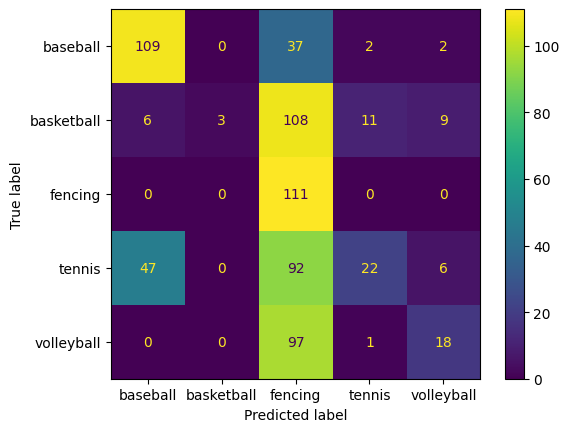

Precision: 0.6095349067633712
Recall: 0.40709468352497125
Accuracy: 0.38619676945668135
F1-score: 0.3192030063228113 




In [11]:
# Metrics for VGG16
print("METRICS FOR VGG16:")
print_video_metrics(true_labels, vgg_pred_labels)